# Setup

In [2]:
! pip install pdfplumber

     |████████████████████████████████| 51kB 2.6MB/s 
     |████████████████████████████████| 5.6MB 5.2MB/s 
     |████████████████████████████████| 143kB 36.5MB/s 
     |████████████████████████████████| 1.9MB 31.8MB/s 
  Created wheel for pdfplumber: filename=pdfplumber-0.5.27-cp37-none-any.whl size=32071 sha256=8b44eaf1cef2f91d5c4378b32846dbfffa813825f6c6125351e6f084811787d3
  Stored in directory: /root/.cache/pip/wheels/b4/74/fc/f7b3a1a0732209027fb48a5f4392fc40d79970b11c2ba49e71
Successfully built pdfplumber


In [3]:
#! pip uninstall googletrans
! pip install googletrans==3.1.0a0
#! pip install googletrans

     |████████████████████████████████| 61kB 3.0MB/s 
     |████████████████████████████████| 1.0MB 6.9MB/s 
     |████████████████████████████████| 51kB 4.9MB/s 
     |████████████████████████████████| 61kB 5.9MB/s 
     |████████████████████████████████| 71kB 5.1MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-cp37-none-any.whl size=16368 sha256=1d6000669a7dcd36bc9aad6f9661799ce84888b17453745cd5d2dbb8deab96fa
  Stored in directory: /root/.cache/pip/wheels/27/7a/a0/aff3babbb775549ce6813cb8fa7ff3c0848c4dc62c20f8fdac
Successfully built googletrans


In [664]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import tensorflow as tf
import xml.etree.ElementTree as ET
import re
from html.parser import HTMLParser
from os import listdir, mkdir, getcwd, chdir
from os.path import join
import pdfplumber
from googletrans import Translator
import nltk
nltk.download('averaged_perceptron_tagger')
import requests
import zipfile
from collections import OrderedDict
from scipy.linalg import norm
from google.colab import files

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [5]:
home_directory = getcwd()

# Download and preprocess regulations

## Download and process FAA

In [6]:
if 'dataset' not in listdir():
    mkdir('dataset')

chdir(home_directory)
chdir(join(home_directory, 'dataset'))
!wget https://www.govinfo.gov/bulkdata/ECFR/title-14/ECFR-title14.xml
chdir(home_directory)

--2021-04-12 12:11:27--  https://www.govinfo.gov/bulkdata/ECFR/title-14/ECFR-title14.xml
Resolving www.govinfo.gov (www.govinfo.gov)... 104.16.165.242, 104.16.164.242, 2606:4700::6810:a5f2, ...
Connecting to www.govinfo.gov (www.govinfo.gov)|104.16.165.242|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16493315 (16M) [text/xml]
Saving to: ‘ECFR-title14.xml’

ECFR-title14.xml    100%[===================>]  15.73M  13.5MB/s    in 1.2s    

2021-04-12 12:11:28 (13.5 MB/s) - ‘ECFR-title14.xml’ saved [16493315/16493315]



In [7]:
# access the raw xml file
filepath = join('dataset', 'ECFR-title14.xml')
tree = ET.parse(filepath)
root = tree.getroot()

# create lists for each regulation
part23, part25, part27, part29, part121, part125, part135 = [],[],[],[],[],[],[]

# iterate over each element of the xml tree and fill corresponding lists
for element in root.iter():
    # stop when DoT part is reached
    if element.tag == 'DIV1':
        if element.attrib['N'] == '4':
            break 
        # if reached a new section
    if element.tag == 'DIV8':
        if '§ 23.' in element.attrib['N']:
            section = []
            [section.append(line) for line in element.itertext() if line[0] != '\n']
            part23.append(' '.join(section))
        elif '§ 25.' in element.attrib['N']:
            section = []
            [section.append(line) for line in element.itertext() if line[0] != '\n']
            part25.append(' '.join(section))
        elif '§ 27.' in element.attrib['N']:
            section = []
            [section.append(line) for line in element.itertext() if line[0] != '\n']
            part27.append(' '.join(section))
        elif '§ 29.' in element.attrib['N']:
            section = []
            [section.append(line) for line in element.itertext() if line[0] != '\n']
            part29.append(' '.join(section))
        elif '§ 121.' in element.attrib['N']:
            section = []
            [section.append(line) for line in element.itertext() if line[0] != '\n']
            part121.append(' '.join(section))
        elif '§ 125.' in element.attrib['N']:
            section = []
            [section.append(line) for line in element.itertext() if line[0] != '\n']
            part125.append(' '.join(section))
        elif '§ 135.' in element.attrib['N']:
            section = []
            [section.append(line) for line in element.itertext() if line[0] != '\n']
            part135.append(' '.join(section))

## Download and preprocess EASA Part-CAT

In [8]:
if 'dataset' not in listdir():
    mkdir('dataset')

chdir(join(home_directory, 'dataset'))
!wget -O EASA-Air-Ops.html https://eur-lex.europa.eu/legal-content/EN/TXT/HTML/?uri=CELEX:02012R0965-20201231&qid=1617989856145&from=EN
chdir(home_directory)

--2021-04-12 12:12:15--  https://eur-lex.europa.eu/legal-content/EN/TXT/HTML/?uri=CELEX:02012R0965-20201231
Resolving eur-lex.europa.eu (eur-lex.europa.eu)... 65.8.173.28, 65.8.173.129, 65.8.173.34, ...
Connecting to eur-lex.europa.eu (eur-lex.europa.eu)|65.8.173.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘EASA-Air-Ops.html’

EASA-Air-Ops.html       [ <=>                ]   3.00M  18.7MB/s    in 0.2s    

2021-04-12 12:12:16 (18.7 MB/s) - ‘EASA-Air-Ops.html’ saved [3145934]



In [9]:
class MyHTMLParser(HTMLParser):
    def __init__(self, output_string, **kwargs):
        self.output_string = output_string
        super().__init__(**kwargs)

    def handle_data(self, data):
        text = re.sub('^\s*', '', data)
        if len(text) > 0 and text[0] != '►' and text[0] != '▼' and text[0] != '◄':
            self.output_string += text + '\n'
            #print(text)

In [10]:
filepath = join('dataset', 'EASA-Air-Ops.html')

parser = MyHTMLParser(output_string = '')

with open(filepath) as file:
    text = file.read()

parser.feed(text)

filepath = join('dataset', 'EASA-Air-Ops.txt')

with open(filepath, 'w') as file:
    file.write(parser.output_string)

In [11]:
filepath = join('dataset', 'EASA-Air-Ops.txt')

partCAT = []

with open(filepath) as file:
    for line in file:
        if line == "ANNEX V\n":
            break
        elif re.match('CAT\.[A-Z]{1,3}\.[A-Z]{1,3}', line):
            partCAT.append(line)
        elif len(partCAT) > 0:
            partCAT[-1] += line

## Download and process ANAC RBAC 121

Download and process RBAC 121 in Portuguese

In [12]:
if 'dataset' not in listdir():
    mkdir('dataset')

chdir(join(home_directory, 'dataset'))
!wget -O RBAC121.pdf https://www.anac.gov.br/assuntos/legislacao/legislacao-1/rbha-e-rbac/rbac/rbac-121/@@display-file/arquivo_norma/RBAC121EMD12.pdf
chdir(home_directory)

--2021-04-12 12:12:53--  https://www.anac.gov.br/assuntos/legislacao/legislacao-1/rbha-e-rbac/rbac/rbac-121/@@display-file/arquivo_norma/RBAC121EMD12.pdf
Resolving www.anac.gov.br (www.anac.gov.br)... 189.3.93.48
Connecting to www.anac.gov.br (www.anac.gov.br)|189.3.93.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2566111 (2.4M) [application/pdf]
Saving to: ‘RBAC121.pdf’

RBAC121.pdf         100%[===================>]   2.45M   671KB/s    in 3.7s    

2021-04-12 12:12:58 (671 KB/s) - ‘RBAC121.pdf’ saved [2566111/2566111]



In [13]:
filepath = join('dataset', 'RBAC121.pdf')
text = ''

with pdfplumber.open(filepath) as pdf:
    #for page in range(len(pdf.pages)):
    for page in range(9,243):
        text += pdf.pages[page].extract_text()

filepath = join('dataset', 'RBAC121.txt')
with open(filepath, 'w') as file:
    file.write(text)

In [14]:
filepath = join('dataset', 'RBAC121.txt')

RBAC121 = []

with open(filepath) as file:
    for line in file:
        if (re.match(' Data da emissão', line) or 
            re.match('Data de vigência', line) or 
            re.match('Origem: SPO', line) or
            not re.match('\w', line)):
            pass
        elif re.match('^121\.\d{1,4}  ', line):
            RBAC121.append(line)
        elif len(RBAC121) > 0:
            RBAC121[-1] += line

Create lists containing each section translation and translation status

In [15]:
RBAC121_lang = np.repeat(np.array('pt'), len(RBAC121)).tolist()
RBAC121_en = np.repeat(np.array(''), len(RBAC121)).tolist()
RBAC121_extra_data = np.repeat(np.array(''), len(RBAC121)).tolist()

Translate each section using the google translate service. Run this code every few hours until all sentences are translated:

In [17]:
translator = Translator()

for section in range(len(RBAC121)):
    if RBAC121_lang[section] == 'pt':
        translation = translator.translate(RBAC121[section], dest='en', src='pt')
        RBAC121_en[section] = translation.text
        RBAC121_extra_data[section] = translation.extra_data
        if translation.extra_data['original-language'] == 'pt':
            RBAC121_lang[section] = 'en'

print('Translated sentences: {} out of {}'.format(RBAC121_lang.count('en'), len(RBAC121_lang)))

Translated sentences: 289 out of 360


Save the full translation to .txt file.

In [ ]:
filepath = join('dataset', 'RBAC121_en.txt')

with open(filepath, 'w', encoding='utf-8') as file:
    for section in RBAC121_en:
        file.write(section + '\n<EOS>\n')

Load translated RBAC121 from .txt file

In [230]:
filepath = join('dataset', 'RBAC121_en.txt')

RBAC121_en = ['']

with open(filepath, 'r', encoding='utf-8') as file:
    for line in file:
        if re.match('<EOS>',line):
            RBAC121_en.append('')
        else:
            RBAC121_en[-1] += line

_ = RBAC121_en.pop()

If file is not completely translated, download a pre-translated version from URL

In [24]:
URL = 'https://raw.githubusercontent.com/fabio-a-oliveira/ds-sandbox/master/RBAC/RBAC121_en.txt'

if RBAC121_lang.count('en') < len(RBAC121_lang):
    # download and save file
    RBAC121_en = ['']
    r = requests.get(URL)
    # save file
    with open(join(home_directory, 'dataset', 'RBAC121_en.txt'), mode='wb') as file:
        file.write(r.content)
    # read file
    with open(join(home_directory, 'dataset', 'RBAC121_en.txt'), encoding='utf-8') as file:
        for line in file:
            if re.match('<EOS>', line):
                RBAC121_en.append('')
            else:
                RBAC121_en[-1] += line

_ = RBAC121_en.pop()

# Create some text tools

## Tokenizer

In [488]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token = '<OOV>')
tokenizer.fit_on_texts(part23 + part25 + part27 + part29 + part121 + part125 + part135 + partCAT + RBAC121_en)
#tokenizer.fit_on_texts(part23 + part25 + part27 + part29 + part121 + part125 + part135 + partCAT)
stop_words = {'ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than'}

In [472]:
tokens = tokenizer.word_index.keys()
discard = []
keep = []

for item in nltk.pos_tag(tokens):
    if item[1] not in ['NN', 'NNS', 'NNP', 'NNPS', 'RB', 'VB', 'JJ']:
        discard.append(item[0])
    else:
        keep.append(item[0])

In [473]:
discard = set(discard).union(stop_words)

In [474]:
tokens = tokenizer.texts_to_sequences(discard)
tokens = [token[0] for token in tokens if len(token)==1]
non_stop_words_indices = [index for index in np.arange(len(tokenizer.word_index)).tolist() if index not in tokens]

In [475]:
sequence = tokenizer.texts_to_sequences([part121[0]])
tokenizer.sequences_to_texts(sequence)

["§ 121 1 applicability this part prescribes rules governing a the domestic flag and supplemental operations of each person who holds or is required to hold an air carrier certificate or operating certificate under part 119 of this chapter b each person employed or used by a certificate holder conducting operations under this part including maintenance preventive maintenance and alteration of aircraft c each person who applies for provisional approval of an advanced qualification program curriculum curriculum segment or portion of a curriculum segment under sfar no 58 of 14 cfr part 121 and each person employed or used by an air carrier or commercial operator under this part to perform training qualification or evaluation functions under an advanced qualification program under sfar no 58 of 14 cfr part 121 d nonstop commercial air tours conducted for compensation or hire in accordance with § 119 1 e 2 of this chapter must comply with drug and alcohol requirements in §§ 121 455 121 457 

In [476]:
matrix_part23 = tokenizer.texts_to_matrix(part23)[:, non_stop_words_indices]
matrix_part25 = tokenizer.texts_to_matrix(part25)[:, non_stop_words_indices]
matrix_part27 = tokenizer.texts_to_matrix(part27)[:, non_stop_words_indices]
matrix_part29 = tokenizer.texts_to_matrix(part29)[:, non_stop_words_indices]
matrix_part121 = tokenizer.texts_to_matrix(part121)[:, non_stop_words_indices]
matrix_part125 = tokenizer.texts_to_matrix(part125)[:, non_stop_words_indices]
matrix_part135 = tokenizer.texts_to_matrix(part135)[:, non_stop_words_indices]
matrix_partCAT = tokenizer.texts_to_matrix(partCAT)[:, non_stop_words_indices]
matrix_RBAC121 = tokenizer.texts_to_matrix(RBAC121_en)[:, non_stop_words_indices]

In [477]:
matrix_part23.shape

(68, 5553)

## Keyword identification: TF-IDF calculating function

In [75]:
def sorted_keywords(excerpt, tokenizer):
    tk = tf.keras.preprocessing.text.Tokenizer()
    tk.fit_on_texts([excerpt])
    tokens, tf_idf = [], []
    for token, freq in tk.word_counts.items():
        dict_freq = tokenizer.word_counts[token]
        tokens.append(token)
        tf_idf.append(freq / np.log(1+dict_freq))
    sorting_indices = (np.array(tf_idf) * (-1)).argsort().tolist()
    return OrderedDict(zip(np.array(tokens)[sorting_indices], np.array(tf_idf)[sorting_indices]))


In [76]:
sorted_keywords(part121[0], tokenizer)

OrderedDict([('an', 1.4587823899517773),
             ('458', 1.4426950408889634),
             ('or', 1.4382187541780396),
             ('to', 1.4064990440012044),
             ('part', 1.367137572075293),
             ('of', 1.3166842267432821),
             ('121', 1.168511825164439),
             ('who', 1.1635334340818608),
             ('aircraft', 1.100576132205754),
             ('this', 1.0611507280365777),
             ('under', 1.0581169179238312),
             ('the', 1.0536919536832248),
             ('person', 0.9899976146449193),
             ('carrier', 0.9479778873476555),
             ('maintenance', 0.941172806314155),
             ('misuse', 0.9102392266268373),
             ('328', 0.9102392266268373),
             ('455', 0.9102392266268373),
             ('65925', 0.9102392266268373),
             ('tours', 0.9102392266268373),
             ('certificate', 0.9002896023506152),
             ('drug', 0.8685889638065035),
             ("operator's", 0.86561702453337

## Clean text according to part-of-speech (POS)

In [238]:
def relevant_words(excerpt):
    tokens = re.findall('[a-zA-Z]{3,}', excerpt)
    words, allowed_pos = [], ['NN','NNS','NNP','NNPS','JJ','RB','VB','VBG','VBN','VBP','VBZ','VBD']
    for item in nltk.pos_tag(tokens):
        if item[0] not in words and item[1] in allowed_pos:
            words.append(item[0])
    return words

In [242]:
print(relevant_words(part121[0]))
print(relevant_words(part121[1]))
print(relevant_words(part121[2]))

['Applicability', 'part', 'prescribes', 'rules', 'governing', 'domestic', 'flag', 'supplemental', 'operations', 'person', 'holds', 'required', 'hold', 'Air', 'Carrier', 'Certificate', 'Operating', 'chapter', 'employed', 'used', 'certificate', 'holder', 'conducting', 'including', 'maintenance', 'preventive', 'alteration', 'aircraft', 'applies', 'provisional', 'approval', 'Advanced', 'Qualification', 'Program', 'curriculum', 'segment', 'portion', 'SFAR', 'CFR', 'air', 'carrier', 'commercial', 'operator', 'perform', 'training', 'qualification', 'evaluation', 'functions', 'Nonstop', 'Commercial', 'Tours', 'conducted', 'compensation', 'hire', 'accordance', 'comply', 'drug', 'alcohol', 'requirements', 'provisions', 'subpart', 'September', 'does', 'not', 'operating', 'permitted', 'otherwise', 'authorized', 'duties', 'subject', 'anti', 'misuse', 'prevention', 'programs', 'Aircraft', 'transport', 'nautical', 'miles', 'further', 'repair', 'point', 'closest', 'principal', 'base', 'obtain', 'servi

In [305]:
print(relevant_words(part121[0]))
print(relevant_words(RBAC121_en[0]))

['Applicability', 'part', 'prescribes', 'rules', 'governing', 'domestic', 'flag', 'supplemental', 'operations', 'person', 'holds', 'required', 'hold', 'Air', 'Carrier', 'Certificate', 'Operating', 'chapter', 'employed', 'used', 'certificate', 'holder', 'conducting', 'including', 'maintenance', 'preventive', 'alteration', 'aircraft', 'applies', 'provisional', 'approval', 'Advanced', 'Qualification', 'Program', 'curriculum', 'segment', 'portion', 'SFAR', 'CFR', 'air', 'carrier', 'commercial', 'operator', 'perform', 'training', 'qualification', 'evaluation', 'functions', 'Nonstop', 'Commercial', 'Tours', 'conducted', 'compensation', 'hire', 'accordance', 'comply', 'drug', 'alcohol', 'requirements', 'provisions', 'subpart', 'September', 'does', 'not', 'operating', 'permitted', 'otherwise', 'authorized', 'duties', 'subject', 'anti', 'misuse', 'prevention', 'programs', 'Aircraft', 'transport', 'nautical', 'miles', 'further', 'repair', 'point', 'closest', 'principal', 'base', 'obtain', 'servi

## SELECT IMPORTANT KEYWORDS BASED ON CLEAN TOKENS

## Custom distance metrics

### Jaccard

In [269]:
def jaccard(string1, string2):
    set1 = set(relevant_words(string1))
    set2 = set(relevant_words(string2))
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union)

In [271]:
jaccard(part121[0], RBAC121_en[0])

0.13970588235294118

### Modified Jaccard

In [494]:
def jaccard_mod(string1, string2, max_words = 1000):
    cutoff = .5
    tokens1 = tokenizer.texts_to_sequences(relevant_words(string1)[:max_words])
    tokens2 = tokenizer.texts_to_sequences(relevant_words(string2)[:max_words])

    if len(tokens1) < 2 or len(tokens2) < 2:
        return 0
    else:
        embedding1 = embedding_layer(np.array(tokens1)).numpy().squeeze()
        norms1 = norm(embedding1, axis=1)
        embedding1 = embedding1[norms1 != 0]
        norms1 = norms1[norms1 != 0].reshape([-1,1])

        embedding2 = embedding_layer(np.array(tokens2)).numpy().squeeze()
        norms2 = norm(embedding2, axis=1)
        embedding2 = embedding2[norms2 != 0]
        norms2 = norms2[norms2 != 0].reshape([-1,1])

        cosine_similarity = np.matmul(embedding1, embedding2.T) / norms1 / norms2.T
        tril = np.ones_like(cosine_similarity) * (np.tril(cosine_similarity) != 0).astype(int)

        intersection = np.sum((cosine_similarity * cosine_similarity) > cutoff)
        union = cosine_similarity.shape[0] + cosine_similarity.shape[1] - intersection

        return intersection/union

In [498]:
jaccard_mod(part121[18], RBAC121_en[0], max_words = 1000)

0.041237113402061855

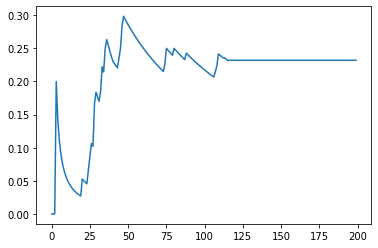

In [497]:
excerpt1 = RBAC121_en[0]
excerpt2 = part121[0]

jac = np.zeros(200)

for i in range(3,200):
    jac[i] = jaccard_mod(excerpt1, excerpt2, i)

plt.plot(jac)
plt.show()

# Pre-trained embedding

## Download GloVe pre-trained embeddings

In [274]:
URL = 'http://nlp.stanford.edu/data/glove.6B.zip'

if 'GloVe' not in listdir():
    mkdir('GloVe')
    
current_directory = getcwd()
chdir(join(current_directory, 'GloVe'))

r = requests.get(URL)
with open('glove.6B.zip', 'wb') as file:
    file.write(r.content)

chdir(current_directory)

## Unzip embeddings

In [275]:
chdir(join(home_directory, 'GloVe'))

zip = zipfile.ZipFile('glove.6B.zip')
zip.extractall()

chdir(home_directory)

## Prepare dictionary with embedding vectors

In [478]:
embedding_dict = {}

with open(join(getcwd(), 'GloVe', 'glove.6B.300d.txt'), encoding='UTF-8') as file:
    for line in file:
        token, vector = line.split(maxsplit=1)
        embedding_dict[token] = np.array(vector.replace('\n','').split(' ')).astype('float')

#tokens = list(embedding_dict.keys())
#embedding_matrix = np.array(list(embedding_dict.values()))

## Create embedding layer

In [479]:
dict_size = len(tokenizer.word_index)
embedding_dim = 300
embedding_vectors = [np.zeros(embedding_dim)]

for word, index in tokenizer.word_index.items():
    embedding = embedding_dict.get(word)
    if embedding is None:
        embedding_vectors.append(np.zeros(embedding_dim))
    else:
        embedding_vectors.append(embedding)

embedding_matrix = np.array(embedding_vectors)

In [480]:
embedding_layer = tf.keras.layers.Embedding(input_dim = dict_size + 1, 
                                            output_dim = embedding_dim, 
                                            embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
                                            trainable=False)

# Embedding - Part 121 vs Part CAT

## Calculate embedding matrices for part 121 and part CAT

In [403]:
def make_embedding_matrix(regulation):
    sequences = tokenizer.texts_to_sequences(regulation)
    padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences)
    sentence_embeddings = embedding_layer(padded_sequences)
    embedding_matrix = tf.reduce_mean(sentence_embeddings, axis=1).numpy()
    return embedding_matrix

In [404]:
embedding_matrix_part121 = make_embedding_matrix(part121)
embedding_matrix_partCAT = make_embedding_matrix(partCAT[:216]) # WTF?! partCAT[:217] -> ERROR

In [405]:
embedding_matrix_part121.shape, embedding_matrix_partCAT.shape

((390, 300), (216, 300))

## Search for related sections between part 121 and part CAT

In [190]:
distance = np.zeros([embedding_matrix_part121.shape[0], embedding_matrix_partCAT.shape[0]])

for i in range(distance.shape[0]):
    for j in range(distance.shape[1]):
        distance[i,j] = cosine(embedding_matrix_part121[i,:], embedding_matrix_partCAT[j,:])

In [200]:
distance.max()

0.09497588872909546

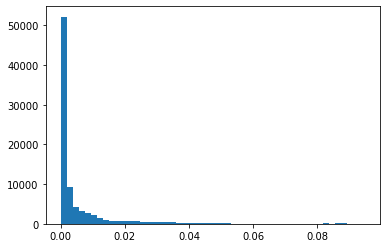

In [195]:
plt.hist(distance.flatten(), 50)
plt.show()

In [259]:
part121_indices = distance.argmax(axis=0)
partCAT_indices = np.arange(distance.shape[1])

index = 0
index = distance.min(axis=0).argsort()[index]

excerpt_part121 = part121[part121_indices[index]]
excerpt_partCAT = partCAT[partCAT_indices[index]]

print('cosine distance: {}'.format(distance.max(axis=0)[index]))
print('--------------------------------------------------------------------------------------------\n')
print(excerpt_partCAT[:200])
print('\n============================================================================================\n')
print(excerpt_part121[:200])

IndexError: ignored

## Make dendrogram for part 121 and part CAT

In [167]:
# calculate distance matrix
matrices = (embedding_matrix_part121, embedding_matrix_partCAT)

distance_matrix = linkage(np.vstack(matrices),
                          metric = 'cosine')

# labels: number and title
labels_part121 = ['.'.join(section.split('.')[:2]) for section in part121]
labels_partCAT = [' '.join(section.split('\n')[:2]) for section in partCAT[:216]]

labels = labels_part121 + labels_partCAT

# plot dendrogram
plt.figure(figsize=(20,400))
dn = dendrogram(distance_matrix,
                labels = labels,  
                orientation = 'left', 
                color_threshold = 1,
                leaf_font_size = 20)

Output hidden; open in https://colab.research.google.com to view.

# Embedding - Part 121 vs RBAC 121

## Calculate embedding matrices

In [406]:
embedding_matrix_RBAC121 = make_embedding_matrix(RBAC121_en)

## Search for related sections

In [407]:
#distance = np.zeros([embedding_matrix_part121.shape[0], embedding_matrix_RBAC121.shape[0]])

#for i in range(distance.shape[0]):
#    for j in range(distance.shape[1]):
#        distance[i,j] = cosine(embedding_matrix_part121[i,:], embedding_matrix_RBAC121[j,:])

        # IMPLEMENTAR DISTÂNCIA JACCARD
        # implementar jaccard modificada, considerando palavras próximas são iguais
        # implementar jaccard modiicada com pesos, considerando frequência
        # IMPLEMENTAR OUTRAS MEDIDAS DE SIMILARIDADE

#distance.max()


1.0348315834999084

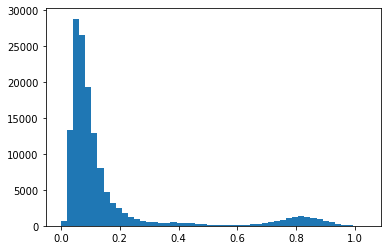

In [409]:
plt.hist(distance.flatten(), 50)
plt.show()

In [410]:
part121_indices = distance.argmin(axis=0)
RBAC121_indices = np.arange(distance.shape[1])

index = 3
#index = distance.min(axis=0).argsort()[index]

excerpt_part121 = part121[part121_indices[index]]
excerpt_RBAC121 = RBAC121_en[RBAC121_indices[index]]

print('cosine distance: {}'.format(distance.min(axis=0)[index]))
print('--------------------------------------------------------------------------------------------\n')
print(excerpt_RBAC121[:200])
print('\n============================================================================================\n')
print(excerpt_part121[:200])

cosine distance: 0.04377412796020508
--------------------------------------------------------------------------------------------

121.4 Applicability of the rules for unauthorized operators
The rules of this regulation that refer to a person certified according to RBAC 119 apply
also, to any person who engages in operations gove


§ 121.903   General requirements for Advanced Qualification Programs. (a) A curriculum approved under an AQP may include elements of existing training programs under part 121 and part 135 of this chap


In [412]:
index_RBAC = 3
index_FAR = 2
print('cosine distance: {}'.format(cosine(embedding_matrix_RBAC121[index_RBAC], embedding_matrix_part121[index_FAR])))
print('--------------------------------------------------------------------------------------------\n')
print(RBAC121_en[index_RBAC][:1000].replace('\n',' '))
print('\n============================================================================================\n')
print(part121[index_FAR][:1000])


cosine distance: 0.04612082242965698
--------------------------------------------------------------------------------------------

121.4 Applicability of the rules for unauthorized operators The rules of this regulation that refer to a person certified according to RBAC 119 apply also, to any person who engages in operations governed by this regulation without the appropriate certificate and operating specifications required by RBAC 119. 


§ 121.4   Applicability of rules to unauthorized operators. The rules in this part which refer to a person certificated under part 119 of this chapter apply also to any person who engages in an operation governed by this part without the appropriate certificate and operations specifications required by part 119 of this chapter. 
 [Doc. No. 11675, 37 FR 20937, Oct. 5, 1972, as amended by Amdt. 121-251, 60 FR 65926, Dec. 20, 1995] 





In [535]:
tokens_RBAC = tokenizer.texts_to_sequences([RBAC121_en[index_RBAC]])[0]
tokens_FAR = tokenizer.texts_to_sequences([part121[index_FAR]])[0]

RBAC_only = list(set(tokens_RBAC) - set(tokens_FAR))
FAR_only = list(set(tokens_FAR) - set(tokens_RBAC))
both = list(set(tokens_FAR) & set(tokens_RBAC))

print('RBAC only: {}'.format(len(RBAC_only)))
print(tokenizer.sequences_to_texts([RBAC_only]))
print('\nFAR only: {}'.format(len(FAR_only)))
print(tokenizer.sequences_to_texts([FAR_only]))
print('\nboth: {}'.format(len(both)))
print(tokenizer.sequences_to_texts([both]))
print('\nJaccard: {}'.format(len(both) / (len(RBAC_only)+len(FAR_only)+len(both))))

RBAC only: 7
['regulation operating for that rbac according certified']

FAR only: 26
['dec 20 251 chapter 37 an as § fr no amdt under which part 1972 11675 20937 operation oct 65926 doc 1995 amended 60 5 certificated']

both: 29
['the of and a in to by this also any certificate 121 required specifications operations engages without person 119 who refer governed rules applicability 4 apply appropriate unauthorized operators']

Jaccard: 0.46774193548387094


## Make dendrogram

# Similarity analysis with custom distances

## Part 121 vs RBAC 121

In [500]:
similarity = np.zeros((len(RBAC121_en), len(part121)))

for i in range(len(RBAC121_en)):
    for j in range(len(part121)):
        similarity[i,j] = jaccard_mod(RBAC121_en[i], part121[j])

In [502]:
similarity.shape

(360, 390)

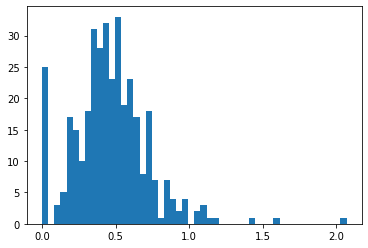

In [505]:
plt.hist(similarity.max(axis=1), 50)
plt.show()

In [517]:
ind = np.unravel_index(similarity.argmax(), similarity.shape)

#print(RBAC121[ind[0]])
#print('----------------')
#print(part121[ind[1]])

jaccard_mod(RBAC121_en[ind[0]], part121[ind[1]])

2.0714285714285716

In [631]:
ind_RBAC = np.arange(len(RBAC121_en))
ind_FAR = similarity.argmax(axis=1)

INDEX = 100 # bad numbers: 9 10 11 19 28 31 50 62 70

print('Jaccard = {}\n'.format(similarity[ind_RBAC[INDEX], ind_FAR[INDEX]]))
print('--------------------------------------------------------------------------------\n')
print(RBAC121_en[ind_RBAC[INDEX]][:200])
print('================================================================================\n')
print(part121[ind_FAR[INDEX]][:200])

Jaccard = 0.5806451612903226

--------------------------------------------------------------------------------

121.287 Transporting cargo in the cargo hold
Cargo carried in cargo compartments, designed in such a way as to require the physical entry of
a crew member to fight any fire that may occur in flight, m

§ 121.287   Carriage of cargo in cargo compartments. When cargo is carried in cargo compartments that are designed to require the physical entry of a crewmember to extinguish any fire that may occur d


## Part 121 vs Part CAT

In [ ]:
similarity_FAA_EASA = np.zeros((len(partCAT), len(part121)))

for i in range(len(partCAT)):
    for j in range(len(part121)):
        print('{}/{} | {}/{}'.format(i,len(partCAT),j,len(part121)))
        similarity_FAA_EASA[i,j] = jaccard_mod(partCAT[i], part121[j])

In [633]:
similarity_FAA_EASA.shape

(224, 390)

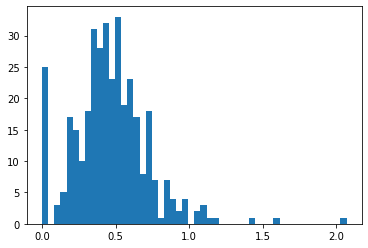

In [634]:
plt.hist(similarity.max(axis=1), 50)
plt.show()

In [661]:
ind_EASA = np.arange(len(partCAT))
ind_FAA = similarity_FAA_EASA.argmax(axis=1)

INDEX = 21 # good indices: 9

print('Jaccard = {}\n'.format(similarity_FAA_EASA[ind_EASA[INDEX], ind_FAA[INDEX]]))
print('--------------------------------------------------------------------------------\n')
print(partCAT[ind_EASA[INDEX]][:200])
print('================================================================================\n')
print(part121[ind_FAA[INDEX]][:200])

Jaccard = 0.13432835820895522

--------------------------------------------------------------------------------

CAT.GEN.MPA.190
Provision of documentation and records
The commander shall, within a reasonable time of being requested to do so by a person authorised by an authority, provide to that person the docu

§ 121.385   Composition of flight crew. (a) No certificate holder may operate an airplane with less than the minimum flight crew in the airworthiness certificate or the airplane Flight Manual approved


# Simple similarity

## Part 121 vs Part 125

In [ ]:
similarity = np.matmul(matrix_part121, matrix_part125.T) / len(tokenizer.word_index)

In [ ]:
np.max(similarity), np.min(similarity)

(0.06513493009645606, 0.0)

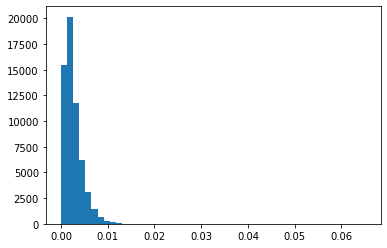

In [ ]:
plt.hist(similarity.flatten(), 50)
plt.show()

In [ ]:
max_coords = np.unravel_index(similarity.argmax(), similarity.shape)
max_coords

(135, 85)

In [ ]:
similarity_indices = np.unravel_index(similarity.argsort(axis=None), similarity.shape)
similarity_indices = np.array(similarity_indices)
similarity_indices

array([[387, 387, 219, ..., 385, 279, 135],
       [ 56, 116,   3, ..., 151,  80,  85]])

In [ ]:
index = 10

print(part121[similarity_indices[0,-1 - index]][:300])
print('\n')
print(part125[similarity_indices[1,-1 - index]][:300])

§ 121.310   Additional emergency equipment. (a)  Means for emergency evacuation.  Each passenger-carrying landplane emergency exit (other than over-the-wing) that is more than 6 feet from the ground with the airplane on the ground and the landing gear extended, must have an approved means to assist 


§ 125.226   Digital flight data recorders. (a) Except as provided in paragraph (l) of this section, no person may operate under this part a turbine-engine-powered transport category airplane unless it is equipped with one or more approved flight recorders that use a digital method of recording and s


## Part 121 vs Part CAT

In [ ]:
similarity = np.matmul(matrix_part121, matrix_partCAT.T) / len(tokenizer.word_index)

In [ ]:
similarity.max()

0.004193044479158102

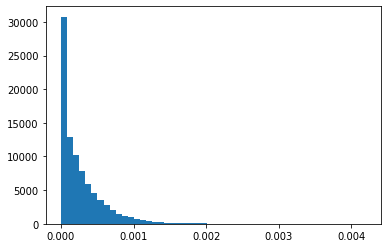

In [ ]:
plt.hist(similarity.flatten(), 50)
plt.show()

In [ ]:
sorting_indices = similarity.argsort(axis=None)
part121_indices, partCAT_indices = np.unravel_index(sorting_indices, shape = similarity.shape)

index = 16

excerpt_part121 = part121[part121_indices[-1-index]]
excerpt_partCAT = partCAT[partCAT_indices[-1-index]]

print(excerpt_part121[:200])
print('\n============================================================================================\n')
print(excerpt_partCAT[:200])

§ 121.574   Oxygen and portable oxygen concentrators for medical use by passengers. (a) A certificate holder may allow a passenger to carry and operate equipment for the storage, generation, or dispen


CAT.IDE.A.235
Supplemental oxygen — pressurised aeroplanes
(a)
Pressurised aeroplanes operated at pressure altitudes above 10 000  ft shall be equipped with supplemental oxygen equipment that is capab


In [ ]:
part121_indices = similarity.argmax(axis=0)
partCAT_indices = np.arange(similarity.shape[1])

#part121_indices.shape, partCAT_indices.shape

index = 24
index = similarity.max(axis=0).argsort()[-1-index]

excerpt_part121 = part121[part121_indices[index]]
excerpt_partCAT = partCAT[partCAT_indices[index]]

print('cosine similarity: {}'.format(similarity.max(axis=0)[index]))
print('--------------------------------------------------------------------------------------------\n')
print(excerpt_partCAT[:200])
print('\n============================================================================================\n')
print(excerpt_part121[:200])

cosine similarity: 0.002384280194031078
--------------------------------------------------------------------------------------------

CAT.OP.MPA.110
Aerodrome operating minima
(a)
The operator shall establish aerodrome operating minima for each departure, destination or alternate aerodrome planned to be used. These minima shall not 


§ 121.419   Pilots and flight engineers: Initial, transition, conversion and upgrade ground training. (a) Except as provided in paragraph (b) of this section, initial and conversion ground training fo


In [ ]:
nltk.bleu_score.sentence_bleu(excerpt_part121, excerpt_partCAT)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.3686599351573761

## Part 121 vs RBAC 121

In [300]:
similarity = np.matmul(matrix_part121, matrix_RBAC121.T) / len(tokenizer.word_index)

In [301]:
similarity.max()

0.019130084575110753

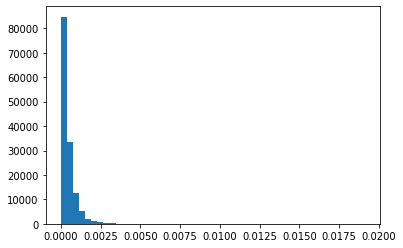

In [302]:
plt.hist(similarity.flatten(), 50)
plt.show()

In [330]:
#sorting_indices = similarity.argsort(axis=None)
#part121_indices, RBAC121_indices = np.unravel_index(sorting_indices, shape = similarity.shape)
RBAC121_indices = np.arange(len(RBAC121)).tolist()
part121_indices = similarity.argmax(axis=0).tolist()

index = 6

excerpt_part121 = part121[part121_indices[index]]
excerpt_RBAC121 = RBAC121[RBAC121_indices[index]]
excerpt_RBAC121_en = RBAC121_en[RBAC121_indices[index]]

print('similarity = {}'.format(similarity.max(axis=0)[index]))
print('bleu score = {}'.format(nltk.bleu_score.sentence_bleu(excerpt_part121, excerpt_RBAC121_en)))
print('\n--------------------------------------------------------------------------------------------\n')
print(excerpt_RBAC121[:200])
print('\n============================================================================================\n')
print(excerpt_part121[:200])
print('\n--------------------------------------------------------------------------------------------\n')

similarity = 0.0011075312122432541
bleu score = 0.5396676627845686

--------------------------------------------------------------------------------------------

121.15  Transporte de drogas narcóticas, maconha e outras drogas ou substâncias depressivas 
ou estimulantes 
Se um detentor de certificado, operando segundo este regulamento, permitir que um avião de


§ 121.135   Manual contents. (a) Each manual required by § 121.133 must - 
 (1) Include instructions and information necessary to allow the personnel concerned to perform their duties and responsibili

--------------------------------------------------------------------------------------------



/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [327]:
RBAC121_en[6]

'121.15 Transport of narcotic drugs, marijuana and other drugs or depressive substances\nor stimulants\nIf a certificate holder, operating under this regulation, allows an airplane of his or her\nowned or leased by him is engaged in any operation that he, the certificate holder,\nknows to be in violation of paragraph 91.19 (a) of RBHA 91, or the regulation that will replace it,\nsuch an operation can serve as a basis for suspension or revocation of the certificate. (Wording given by\nResolution No. 334, of 7/1/2014)\nSUBPART B\nSUBPART C\nSUBPART D\nSUBPART E\nAPPROVAL OF ROUTES FOR REGULAR OPERATIONS (Title of Subpart with\nwording given by Resolution No. 526, of 06.08.2019)\n'

In [328]:
part121[6]

'§ 121.15   Carriage of narcotic drugs, marihuana, and depressant or stimulant drugs or substances. If a certificate holder operating under this part permits any aircraft owned or leased by that holder to be engaged in any operation that the certificate holder knows to be in violation of § 91.19(a) of this chapter, that operation is a basis for suspending or revoking the certificate. \n [Doc. No. 28154, 60 FR 65926, Dec. 20, 1995]\n\n\n'

# Clustering with scipy

## Operational regulations - distance with full text

In [331]:
# calculate distance matrix
#matrices = (matrix_part121, matrix_part125, matrix_part135, matrix_partCAT)
#matrices = (matrix_part121, matrix_part125, matrix_part135)
#matrices = (matrix_part121, matrix_partCAT)
#matrices = (matrix_part121, matrix_RBAC121)
matrices = embedding_matrix_part121, embedding_matrix_RBAC121

distance_matrix = linkage(np.vstack(matrices),
                          metric = 'cosine')

# labels: number and title
labels_part121 = ['.'.join(section.split('.')[:2]) for section in part121]
labels_part125 = ['.'.join(section.split('.')[:2]) for section in part125]
labels_part135 = ['.'.join(section.split('.')[:2]) for section in part135]
labels_partCAT = [' '.join(section.split('\n')[:2]) for section in partCAT]
labels_RBAC121 = [section.split('\n')[0] for section in RBAC121]

#labels = labels_part121 + labels_part125 + labels_part135 + labels_partCAT
#labels = labels_part121 + labels_part125 + labels_part135
#labels = labels_part121 + labels_partCAT
labels = labels_part121 + labels_RBAC121

# plot dendrogram
plt.figure(figsize=(20,400))
dn = dendrogram(distance_matrix,
                labels = labels,  
                orientation = 'left', 
                color_threshold = 1,
                leaf_font_size = 20)

Output hidden; open in https://colab.research.google.com to view.

## Operational regulations - distance with title only

In [ ]:
# calculate distance matrix
distance_matrix = linkage(np.vstack((matrix_part121_title,  
                                     matrix_partCAT_title)),
                          metric = 'cosine')

# labels: number and title
labels = (['.'.join(section.split('.')[:2]) for section in part121] + 
          [' '.join(section.split('\n')[:2]) for section in partCAT])

# plot dendrogram
plt.figure(figsize=(20,400))
dn = dendrogram(distance_matrix,
                labels = labels,  
                orientation = 'left', 
                color_threshold = 1,
                leaf_font_size = 15)

Output hidden; open in https://colab.research.google.com to view.

## Airworthiness regulations

In [ ]:
# calculate distance matrix
distance_matrix = linkage(np.vstack((matrix_part23, matrix_part25, matrix_part27, matrix_part29)),
                          metric = 'cosine')

# labels: number and title
labels = (['.'.join(section.split('.')[0:2]) for section in part23] + 
          ['.'.join(section.split('.')[0:2]) for section in part25] + 
          ['.'.join(section.split('.')[0:2]) for section in part27] +
          ['.'.join(section.split('.')[0:2]) for section in part29])

# plot dendrogram
plt.figure(figsize=(20,200))
dn = dendrogram(distance_matrix,
                labels = labels,  
                orientation = 'left', 
                color_threshold = 1,
                leaf_font_size = 10)

Output hidden; open in https://colab.research.google.com to view.

# Trash

In [ ]:
temp = translator.translate(text, dest='en', src='pt')

WriteError: ignored

In [ ]:
tokens = tokenizer.word_index.keys()
discard = []
keep = []

for item in nltk.pos_tag(tokens):
    if item[1] not in ['NN', 'NNS', 'NNP', 'NNPS', 'RB', 'VB', 'JJ']:
        discard.append(item[0])
    else:
        keep.append(item[0])

len(keep), len(discard)

(7491, 4672)

In [ ]:
dir(stop_words)

['__and__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__iand__',
 '__init__',
 '__init_subclass__',
 '__ior__',
 '__isub__',
 '__iter__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__or__',
 '__rand__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__ror__',
 '__rsub__',
 '__rxor__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__xor__',
 'add',
 'clear',
 'copy',
 'difference',
 'difference_update',
 'discard',
 'intersection',
 'intersection_update',
 'isdisjoint',
 'issubset',
 'issuperset',
 'pop',
 'remove',
 'symmetric_difference',
 'symmetric_difference_update',
 'union',
 'update']

In [ ]:
a = set(['a', 'b', 'c'])
a.update(set(['d']))
a

{'a', 'b', 'c', 'd'}

In [668]:
with open(join(home_directory, 'dataset', 'similarity_FAA_ANAC.h5'), 'wb') as file:
    file.write(similarity)

with open(join(home_directory, 'dataset', 'similarity_FAA_EASA.h5'), 'wb') as file:
    file.write(similarity_FAA_EASA)

files.download(join(home_directory, 'dataset', 'similarity_FAA_ANAC.h5'))
files.download(join(home_directory, 'dataset', 'similarity_FAA_EASA.h5'))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>